# Project 4: Identifying west nile virus hotspots and its exacerbating factors
### Part3: Modelling and Tuning

This section will focus on testing different classification algorithms to understand which performs best on the dataset.

- Introduction on classification metrics and sample balancing techniques
- Modelling and Tuning with Logistic Regression, Random Forest and XGBoost
- Exploration of important Features and Error Analysis

# Contents

Overview on modelling algorithms and classification metrics
- [Modelling Overview](#Modelling-Overview)

Modelling and Results
- [Modelling and Tuning](#Modelling-and-Tuning)

Model Review and Selection
- [Model Review and Selection](#Model-Review-and-Selection)

Error Analysis and Future Directions
- [Error Analysis](#Error-Analysis)
- [Future Directions](#Future-Directions)



In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0.2
GPU is available


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, mean_squared_error


from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)

from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)

from sklearn.preprocessing import (
    StandardScaler,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from xgboost import cv
from xgboost import plot_importance
import xgboost as xgb
use_label_encoder=False

# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

# Exploratory Data Analysis

In [3]:
# read in lag7_g1 dataset
lag_train = pd.read_csv('../data/lag7_g1.csv')
lag_test = pd.read_csv('../data/test_lag7_g1.csv')

Text(0.69, 0.5, '5.39% of 8475 observations\nare from the Positive class (1),\nie. WNV present')

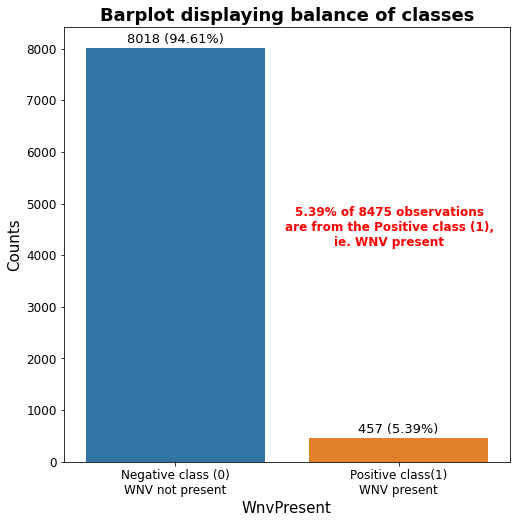

In [4]:
# Plotting the balance of classes on a countplot.

wnv_notpresent = lag_train['wnvpresent'].value_counts()[0]
wnv_present = lag_train['wnvpresent'].value_counts()[1]
neg_pct = lag_train['wnvpresent'].value_counts(normalize=True)[0] * 100
pos_pct = lag_train['wnvpresent'].value_counts(normalize=True)[1] * 100
total = wnv_notpresent + wnv_present

# set up figure size 
plt.figure(figsize=(8,8))

# plot countplot
ax = sns.countplot(x='wnvpresent', data=lag_train)


# set labels for X and y and titles
ax.set_xticklabels(['Negative class (0)\nWNV not present', 'Positive class(1)\nWNV present'])
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("WnvPresent", fontsize=15)
plt.ylabel("Counts", fontsize=15)

plt.title("Barplot displaying balance of classes", fontdict = {'size' : 18, 'weight': 'bold'})

# to plot number of points in each class 
plt.text(x=0, y=wnv_notpresent+100, s=str(wnv_notpresent) + ' (' + str(round(neg_pct,2)) + '%)', fontsize=13, ha='center')
plt.text(x=1, y=wnv_present+100, s=str(wnv_present) + ' (' + str(round(pos_pct,2)) + '%)', fontsize=13, ha='center')

# set up red text 
plt.figtext(x=0.69, 
            y=0.5, 
            s=f"{round(pos_pct, 2)}% of {total} observations\nare from the Positive class (1),\nie. WNV present", 
            fontdict = {'size' : 12, 'weight': 'semibold'},
            ha='center',
            color = 'red',
           )


From the above, we can see that the classes are very unbalanced. Of the 8475 observations, only 457 `(5.5%) are from the positive class` ie. West Nile Virus present (WvvPresent == 1) while 8018 (94.61%) observations from the negative class, ie. West Nile Virus not present (WvvPresent == 0)

We will need to explore ways to balance the two classes before modelling 

# Modelling Overview

## Modelling Approaches

As seen from the above, the classes in this case is unbalanced. We will need to deploy balancing techniques like `over-sampling` using imblearn `SMOTE` and also adjust `class_weights` on certain classifiers like RandomForestClassifier. 

We will be using these following models 
- Logistic Regression  
- RandomForestClassifier
- XGboost 

## Classification Matrix

In the context of this project, we define our **positive class as the presence of WNV *(WnvPresent = 1)*, and the negative class as the absence of WNV *(WnvPresent = 0)***.

`Accuracy` is defined as the total number of correct predictions over the total number of predictions made. Essentially, this refers to the correct predictions of mosquitos trapped containing WNV virus over the total number of predictions made.

While `Accuracy` is a good overall measure of the model's performance, a high score doesnt reflect how well it is predicting for each class. For example, having high score, could also mean having very good predictions of mosquitos NOT having WNV (due to high skew of data towards no WnvPresent), that would overshadow class that contains correct predictions for those carrying WNV. 

Hence we need `sensitivity` and `specificity` as well to measure the true positive and true negative rate and achieve balance between the two. 

To answer the part on `calculating the cost involved to deploy the the pesticides` throughout the city of Chicago, having high amount of false positives will result in increased cost for spraying these pesticides. On the other hand, having `large number of false negatives could potentially lead to an outbreak of WNV which would greatly affect the economy should Chicago be forced to take drastic measures to contain it`. Hence, the team has decided it would be better to focus on having **minimal false negatives than *false positives* hence leaning towards `sensitivity` than `specificity`** while not sacrifising too much on `Accuracy`, `ROC_AUC` (how good the model is at predicting) and `Precision` (used to measure the quality of a ***positive prediction made by the model*** where cost of ***Too many False positives* can be a huge short term impact**)

### Instantiate X and y variables

For this iteration onwards, we will be using two main datasets which was chosen to be the best features based on accuracy and high sensitivity scores while both lags then to fit within the timeframe for complete larval development from 7 to 23 days ([ncbi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3992806/)). 

1) Lag 7 days (group_1) - Based on first pass high test accuracy score
2) Lag 21 days (group_2) - Based on first pass high sensitivity score

Based on internal calculation, we will do `full iteration only on 7 days data`, and will not show the steps for 21 days as even though ROC_AUC results may be good, the results on the test dataset was bad. This could be attributed to the large variability of the weather features impact to the model which may not be able to predict well in unforeseen data across other unknown years. 

In [5]:
X = lag_train.drop(columns = ['wnvpresent','date','id'])
y = lag_train['wnvpresent']

In [6]:
X.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T086,trap_T003,trap_T028,trap_T082,trap_T014,trap_T115,trap_T158,trap_T016,trap_T903,trap_T226,...,trap_T103,trap_T221,trap_T114,trap_T096,trap_T009,trap_T235,trap_T008,trap_T061,trap_T147,trap_T073,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,73.5,44,0.0,29.41,30.05,16,10.6,19.183333,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,65.5,55,0.0,29.52,30.17,3,6.7,17.933333,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,65.5,55,0.0,29.52,30.17,3,6.7,17.933333,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,64.5,55,0.0,29.46,30.18,2,6.4,17.933333,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,72.5,54,0.0,29.46,30.08,31,7.4,18.850000,0,0,0,0,0,0,0


In [7]:
kaggle_test = lag_test.drop(columns = ['wnvpresent','id'])
kaggle_test.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T003,trap_T061,trap_T128,trap_T230,trap_T008,trap_T011,trap_T009,trap_T090,trap_T138,trap_T147,...,trap_T233,trap_T225,trap_T095,trap_T103,trap_T030,trap_T228,trap_T223,trap_T031,trap_T015,trap_T221,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0


In [8]:
kaggle_test.shape

(116293, 76)

Train test split

In [9]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

# Transforming X_test to the same scale.

X_test_sc = ss.transform(X_test)

In [11]:
# Transforming actual test dataframe to the same scale (to generate predictions for kaggle submission later).

kaggle_test_sc = ss.transform(kaggle_test)

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


# Modelling and Tuning

### Class balancing Technique

We will be using only `smote` for this project

In [12]:
# instantiate SMOTE
smote = SMOTE(random_state=42)

In [13]:
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [14]:
# Checking the distribution of classes with SMOTE balancing technique.

y_train_smote.value_counts()

0.0    6013
1.0    6013
Name: wnvpresent, dtype: int64

We can see the library helped balance the proportions between two classes. 

`SMOTE` is an over-sampling method, that creates copies of the minority class data points with small variations, making synthetic samples more diverse [source](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/). Hence we see the number of data points for the positive class matching with the negative class

### Logistic regression & SMOTE

In [15]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and LogisticRegression.

pipe_logreg = make_pipeline(SMOTE(random_state=42),
                      LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=1000)
                     )

In [16]:
pipe_logreg.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('logisticregression',
   LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                      solver='saga'))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'logisticregression': LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                    solver='saga'),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'saga',
 'logisticre

In [18]:
# Establishing ranges of hyperparameters C and l1_ratio for GridSearchCV, and class_weight.

pipe_logreg_params = {
    'logisticregression__C': np.linspace(0,5,10),
    'logisticregression__l1_ratio': [1],
    }

In [19]:
# Creating a GridSearchCV with scoring of ROC_AUC

gs_logreg = GridSearchCV(pipe_logreg, 
                        param_grid=pipe_logreg_params, 
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs = -1
                       )

In [20]:
# Fitting GridSearchCV with SMOTE and LogisticRegression on X_train_sc and y_train.

gs_logreg.fit(X_train_sc, y_train)

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1614, in fit
    for class_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
                         'logisticregression__l1_ratio': [1]},
             scoring='roc_auc')

In [21]:
gs_logreg.best_params_

{'logisticregression__C': 1.1111111111111112,
 'logisticregression__l1_ratio': 1}

In [22]:
# Scoring model for all matrix 

train_acc = gs_logreg.score(X_train_sc, y_train)
cross_val_acc = gs_logreg.best_score_
test_acc = gs_logreg.score(X_test_sc, y_test)
preds = gs_logreg.predict(X_test_sc)
y_pred_proba = gs_logreg.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


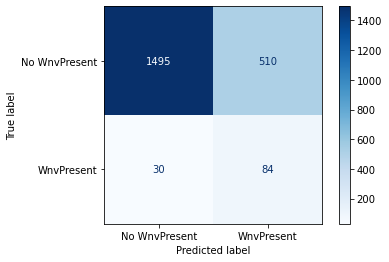

In [23]:
# Plot Confusion matrix
plot_confusion_matrix(gs_logreg, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [24]:
summary_df = pd.DataFrame(columns=['Classifier',
                                   'Class Balancing Technique',
                                   'Train Accuracy',
                                   'GridSearchCV Accuracy',
                                   'Actual Test Accuracy',
                                   'Overfit (-ve) / Underfit (+ve)',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                  ])

In [25]:
summary_df.loc[1] = ["LogisticRegression",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811


### Random Forest Classifier & SMOTE

For this section, we will not be creating GridSearchCV to fine best params as our problem statement involves getting a good balance between multiple parameters like sensitivity, specificity, precision and ROC_AUC. Hence this model will be manually tuned.  

In [26]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and RandomForestClassifier.

rfc_smote_pipe = make_pipeline(
    SMOTE(
        sampling_strategy='minority',
        random_state=42 
    ),
    RandomForestClassifier(n_estimators=1500,
                            ccp_alpha=0.055,
                            max_depth=5,
                            min_samples_split=2,
                            min_samples_leaf=2,
                            random_state=42
                            )
)


In [27]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_smote_pipe.fit(X_train_sc, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0.055, max_depth=5,
                                        min_samples_leaf=2, n_estimators=1500,
                                        random_state=42))])

In [28]:
# Scoring model for all matrix 

train_acc = rfc_smote_pipe.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfc_smote_pipe, X_train_sc,y_train, cv=3).mean()
test_acc = rfc_smote_pipe.score(X_test_sc, y_test)
preds = rfc_smote_pipe.predict(X_test_sc)
y_pred_proba = rfc_smote_pipe.predict_proba(X_test_sc)
confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


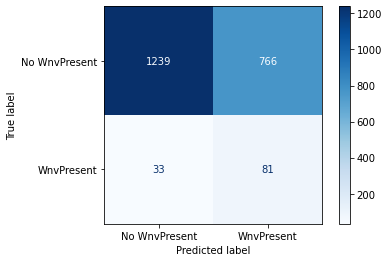

In [29]:
# Plot Confusion matrix
plot_confusion_matrix(rfc_smote_pipe, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [30]:
summary_df.loc[2] = ["RandomForestClassifier",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.623,0.653,0.623,0.000,0.711,0.618,0.096,0.720


After tuning `RandomForestClassifier with Smote`, we can see that `LogisticRegression` has better sensitivity score and ROC_AUC score. 

However, sensitivity will be hard to tune upwards while maintaining high precision and ROC_AUC. Bumping up the sensitivity will bring down overall accuracy, ROC_AUC and Precision. Anything below below ROC_AUC score of 0.8 will not be good as per ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2935260/#:~:text=The%20area%20under%20the%20ROC,AUC%20values%20between%200.5%2D0.6.)). Hence, we can explore tuning RandomForestClassifier with balanced subsample.

### Random Forest Classifier & Hyperparameter class_weight = `balance_subsample`

We will be manually tuning the parameters as GridsearchCV will only optimise the model based on one scoring parameter for similar reason as the previous model

In [31]:
rfs_hyperparam_bal =  RandomForestClassifier(
        n_estimators=1000,
        ccp_alpha=0,
        max_depth=6,
        min_samples_split=3,
        min_samples_leaf=3,
        random_state=42,
        class_weight='balanced_subsample')

In [32]:
# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=6, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [33]:
# Fitting GridSearchCV with Random Forest Classifier

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=6, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [34]:
# Scoring model for all matrix 

train_acc = rfs_hyperparam_bal.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfs_hyperparam_bal,X_train_sc,y_train, cv = 5).mean()
test_acc = rfs_hyperparam_bal.score(X_test_sc, y_test)
preds = rfs_hyperparam_bal.predict(X_test_sc)
y_pred_proba = rfs_hyperparam_bal.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


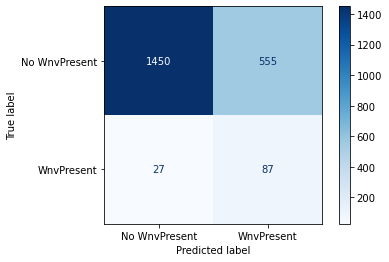

In [35]:
# Plot Confusion matrix
plot_confusion_matrix(rfs_hyperparam_bal, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [36]:
summary_df.loc[3] = ["RandomForestClassifier",
                     "Hyperparameter: Balanced Subsample",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.623,0.653,0.623,0.000,0.711,0.618,0.096,0.720
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.731,0.737,0.725,0.005,0.763,0.723,0.136,0.812


This hyperparameter tuning enables RandomForestClassifier to handle unbalanced dataset without using the oversampling method, SMOTE. Although the test accuracy suffers a little, the sensitivity and ROC_AUC improved with little impact to the rest of the matrix. 

### Support Vector Classifier (SVC) with Smote

In [37]:
svc_smote_pipe3 = make_pipeline(
    SMOTE(
        random_state=42,
    ),
    SVC(
        C=0.025,
        kernel='rbf',
        probability=True, 
        random_state=42
    )
)

In [38]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

svc_smote_pipe3.fit(X_train_sc, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('svc', SVC(C=0.025, probability=True, random_state=42))])

In [39]:
# Scoring model for all matrix 

train_acc = svc_smote_pipe3.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(svc_smote_pipe3, X_train_sc,y_train, cv = 3).mean()
test_acc = svc_smote_pipe3.score(X_test_sc, y_test)
preds = svc_smote_pipe3.predict(X_test_sc)
y_pred_proba = svc_smote_pipe3.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


In [40]:
summary_df.loc[4] = ["SVC",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.623,0.653,0.623,0.000,0.711,0.618,0.096,0.720
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.731,0.737,0.725,0.005,0.763,0.723,0.136,0.812
4,SVC,SMOTE,0.621,0.650,0.591,0.030,0.772,0.581,0.095,0.746


The SVC with Smote despite multiple tuning, was unable to get a good accuracy score while achieving higher sensitivity score. 

SVC is generally difficult to tune to get what we intended to achieve. Overall, its accuracy/specificity score are not as competitive as the rest of the models. Overall ROC_AUC is bad too, hence this model will not be useful.

### XGBoost & Hyperparameter tuned: `Scale_pos_weight`

The following steps below will involve using GridSearchCV followed by manual tuning that to ensure that model is able to predict unseen data from kaggle test set. Learning rate was found to be important, as the faster the learning rate, the more it may miss a few data points or correlations which can give better insights into the data, which may lead to lower predicting power. 

In [41]:
pipe_xgb = Pipeline([    
                    ('xgb',XGBClassifier(
                        objective='binary:logistic',
                        verbosity=1, 
                        n_jobs=-1, 
                        random_state=42, 
                        eval_metric='auc', 
                        use_label_encoder =False)),
                    ])
    
  
pipe_xgb_params = {
'xgb__gamma': [0, 0.5, 1],
'xgb__learning_rate': [0.01, 0.02,0.03],
'xgb__max_depth':[4,5,6],
'xgb__min_child_weight': [3,5,10],
'xgb__scale_pos_weight': [19,20,21],
'xgb__subsample':[0.8,0.9, 1]
}

gs_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=pipe_xgb_params, cv=5, scoring='roc_auc', n_jobs = -1)

gs_xgb.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                      

In [42]:
gs_xgb.best_params_

{'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.03,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 10,
 'xgb__scale_pos_weight': 21,
 'xgb__subsample': 0.8}

Manual finetuning needed to get better sensitivity score

In [43]:
# fit XGBoost on training data

xgb_model = XGBClassifier(
    n_estimators = 1000,
    scale_pos_weight=19,
    learning_rate = 0.02,  
    subsample = 1,
    objective='binary:logistic',
    reg_alpha = 5,
    max_depth= 5, 
    min_child_weight = 3,
    use_label_encoder=False,
    eval_metric = 'auc',
    gamma = 0,
    random_state = 42

)
                  
eval_set = [(X_test_sc,y_test)]

# use AUC as eval matric
xgb_model.fit(
    X_train_sc,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose = False,
    eval_metric='auc'
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=5, reg_lambda=1, scale_pos_weight=19, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [44]:
# Scoring model for all matrix 

train_acc = xgb_model.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(xgb_model, X_train_sc, y_train, cv = 3).mean()
test_acc = xgb_model.score(X_test_sc, y_test)
preds = xgb_model.predict(X_test_sc)
y_pred_proba = xgb_model.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


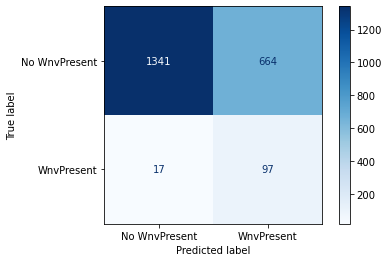

In [45]:
# Plot Confusion matrix
plot_confusion_matrix(xgb_model, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

Significantly, this model predicts the best true positive as compared to other models with relatively lower False positive counts. 

# Model Review and Selection

In [46]:
summary_df.loc[5] = ["XGBoost",
                    'Hyperparameter: Scale_pos_weight',
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.623,0.653,0.623,0.000,0.711,0.618,0.096,0.720
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.731,0.737,0.725,0.005,0.763,0.723,0.136,0.812
4,SVC,SMOTE,0.621,0.650,0.591,0.030,0.772,0.581,0.095,0.746
5,XGBoost,Hyperparameter: Scale_pos_weight,0.691,0.804,0.679,0.012,0.851,0.669,0.127,0.821


`XGBoost` has the `highest ROC_AUC, sensitivity` with relatively better scores for the rest of the matrix compared to the other models. Although it suffers from the train accuracies, it is relatively better fitted, achieving the best balance between bias and variance, allowing the model to predict well with unseen data. 

For this particular model tuning, the initial computational time taken to do the GridsearchCV took quite a long time, for at least 2hours. The subsequent tuning to attain the right balance between sensitivity and specificity while maintaining overall scores of accuracy, precision and ROC_AUC with minimal over-fitting. The overall time taken to tune this was beyond 10hours just on this model. 

# ROC Curve

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

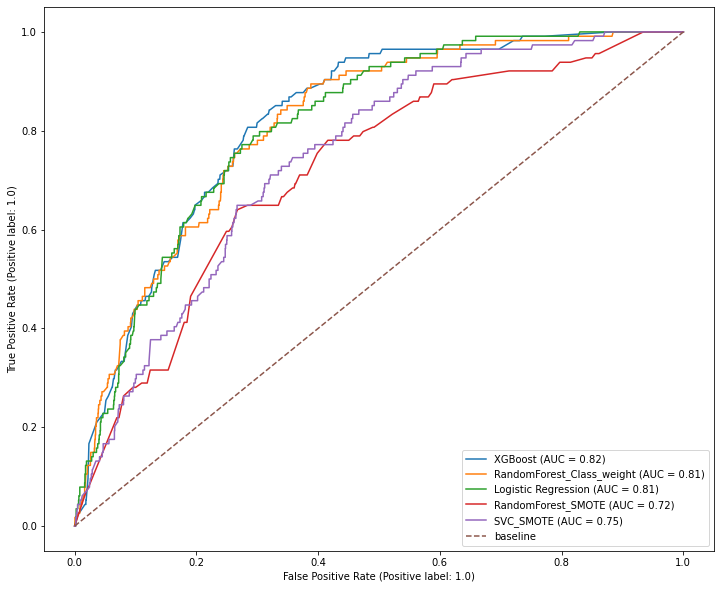

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

plot_roc_curve(xgb_model, X_test_sc, y_test, ax=ax, name = 'XGBoost')
plot_roc_curve(rfs_hyperparam_bal, X_test_sc, y_test, ax=ax, name = 'RandomForest_Class_weight')
plot_roc_curve(gs_logreg, X_test_sc, y_test, ax=ax, name = 'Logistic Regression')
plot_roc_curve(rfc_smote_pipe, X_test_sc, y_test, ax=ax, name =  'RandomForest_SMOTE')
plot_roc_curve(svc_smote_pipe3, X_test_sc, y_test, ax=ax, name = 'SVC_SMOTE')


plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')

plt.legend();

The above plot shows the ROC curve for our models, with the best score coming from XGBoost with AUC value of 0.83. Since it is closer to 1, it shows how the model is able to separate both classes quite well.  

#### Kaggle Submission

In [48]:
# fit in whole data set 
xgb_model.fit(X,y)

# create submission predict proba 
submission_pred_proba= xgb_model.predict_proba(kaggle_test_sc)[:, 1]

# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

submission = pd.DataFrame({'Id' : lag_test['id'].values, 'WnvPresent' : submission_pred_proba})
submission.Id = submission.Id.astype('int')
submission.to_csv('../kaggle_submission/submission_XGBoost_lag_7.csv', index=False)

Kaggle score submitted: 0.67

# Feature importance

In [49]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,40))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

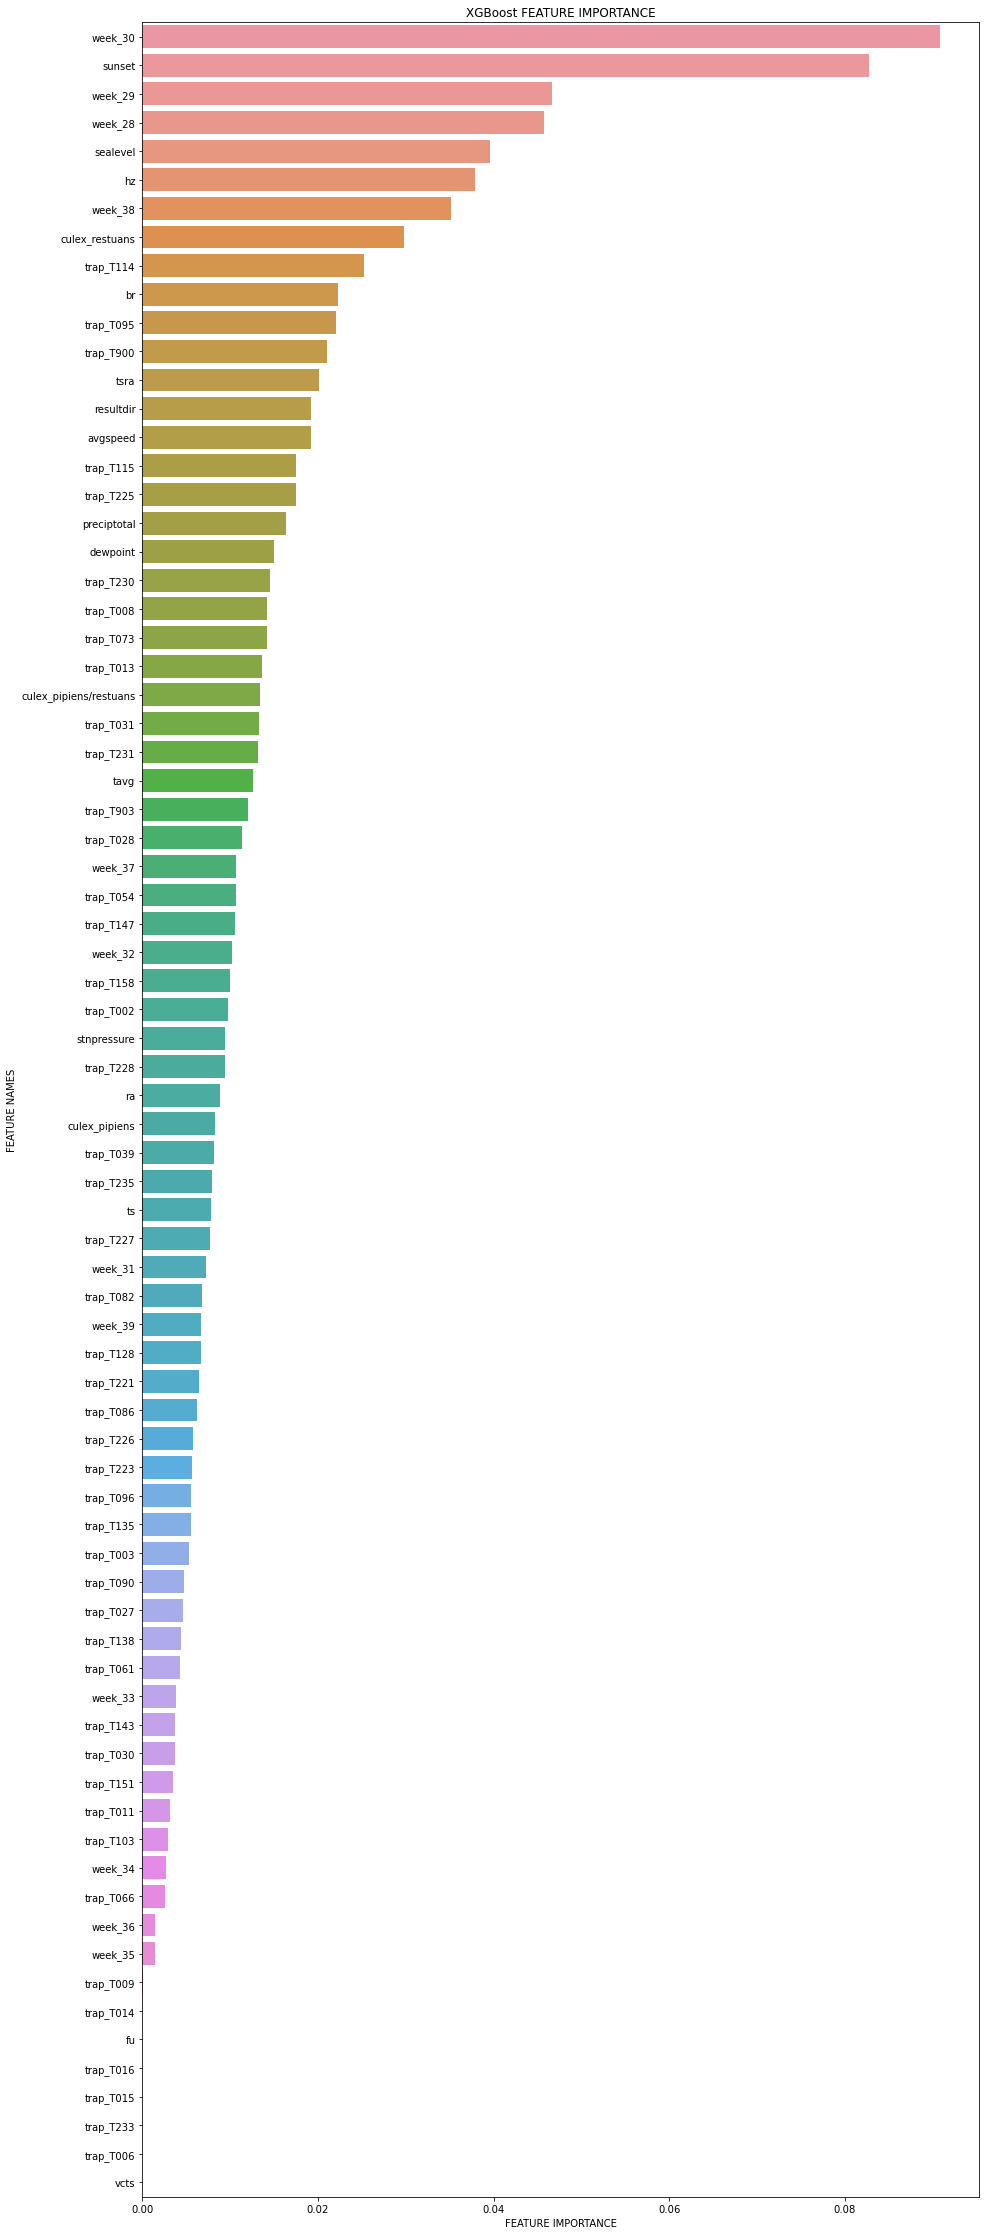

In [50]:
plot_feature_importance(xgb_model.feature_importances_,X.columns,'XGBoost')

The default feature importance from XGBoost calculates the 'gain', which is the average gain of split which uses the particular feature. The higher value of this metric, when compared to another feature implies it is more important for generating a prediction. 
 

An interesting feature that was highlighted was the week 29 and 30, which was highlighted as the highest amongst the rest of the weeks. Based on our initial EDA, we can see that these two weeks were seeing a **start of wnv influx across all the years** as shown in "1_Data_Cleanup_Consolidated".

# Error Analysis

Based on the final model, we will inspect the False Negatives which is of greater interest to our problem. The profile of False Negatives will be explored to understand if they are to be expected, and if there are ways to capture these in future models.

In [51]:
# Create a dataframe containing the predicted and actual wnv in test set

y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values

y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(lag_train.reset_index(), on = 'index')

In [52]:
# merge data back with original data so we can get the trap and species columns

merge_df = pd.read_csv('../data/merged_train.csv')

merge_df['index'] = merge_df.index
train_original = merge_df[['trap', 'species', 'index']]

test_df = y_test_pred_df.merge(train_original, how='left', on='index')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['week'] = test_df['date'].dt.isocalendar().week

new_cols = list(test_df.columns[:5])
new_cols.extend(['trap', 'species', 'week', 'year'])  # select columns of interest from original data

wrong_class = test_df[new_cols]

In [53]:
# Filter out only the False Negatives

fn_filter = (wrong_class['y'] == 1) & (wrong_class['y_pred'] == 0)
fn_only = wrong_class[fn_filter]

In [54]:
# proportion of traps missed out of test set by week

test_df.groupby('week')['wnvpresent'].sum()


test_week = pd.DataFrame(test_df.groupby('week')['wnvpresent'].sum())
test_week.columns = ['y_wnvpresent']
test_week['fn'] = fn_only.groupby('week')['wnvpresent'].sum()
test_week['prop_missed']=test_week['fn']/test_week['y_wnvpresent']
test_week.fillna(0)

,y_wnvpresent,fn,prop_missed
week,,,
22,0.0,0.0,0.000000
23,0.0,0.0,0.000000
24,0.0,0.0,0.000000
25,0.0,0.0,0.000000
26,0.0,0.0,0.000000
27,0.0,0.0,0.000000
28,2.0,2.0,1.000000
29,5.0,2.0,0.400000
30,5.0,4.0,0.800000


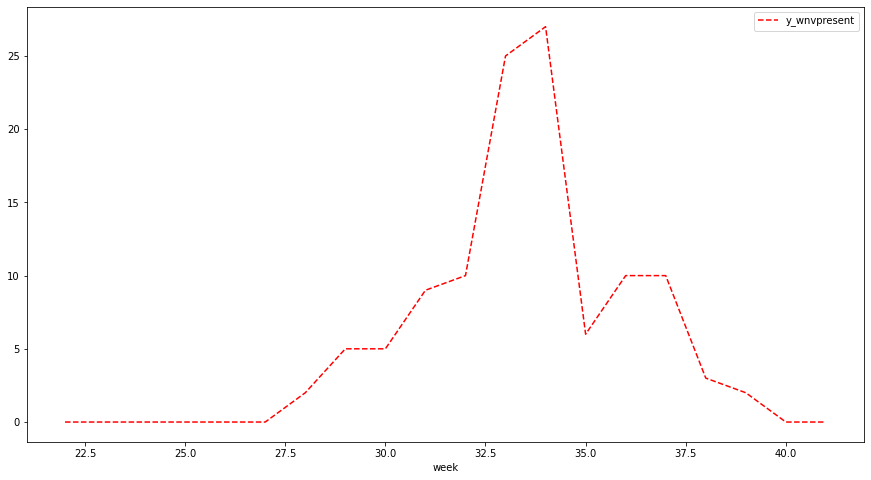

In [55]:
# plot wnvpresent trend 
plt.figure(figsize= (15,8))

test_week['y_wnvpresent'].plot.line(color = 'red', ls =  '--')
plt.legend()

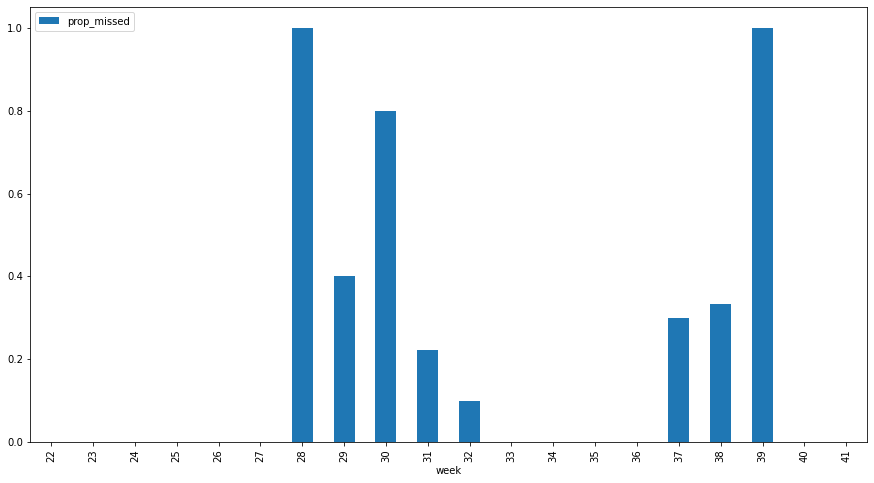

In [56]:
# plot prop_missed trend 

plt.figure(figsize= (15,8))
test_week['prop_missed'].plot.bar()
plt.legend()

Looking at the 'prop_missed' column, we can see the proportion of traps missed by the model (ie. sensitivity by week). The model was generally better at detecting WNV for weeks that had higher WNV counts (weeks 32 to 36), and weaker for the other weeks. This is expected as the peak of the WNV wave is at week 33, and the model would likely have placed higher importance on weeks around 33.

Nonetheless, it shows that the model is poor at picking up occurences of WNVpresent at the onset and the tail end of the WNV wave.

In [57]:
# merge_df['wnvpresent', 'species'].groupby('species')['wnvpresent']
test_species = pd.DataFrame(test_df.loc[test_df['wnvpresent']==1,'species'].value_counts())
test_species.columns = ['y_wnvpresent']
test_species['fn'] = fn_only.groupby('species')['wnvpresent'].sum()
test_species['prop_missed']=test_species['fn']/test_species['y_wnvpresent']
test_species


,y_wnvpresent,fn,prop_missed
CULEX PIPIENS/RESTUANS,56,9.0,0.160714
CULEX PIPIENS,45,3.0,0.066667
CULEX RESTUANS,13,5.0,0.384615


Looking at the 'prop_missed' column once again, we can see that there is a higher propoortion missed for CULEX PIPIENS/RETUANS and CULEX RESTUANS as compared to CULEX PIPIENS. This is not surprising as the proportion of CULEX PIPIENS which carry the WNV is HIGHER than CULEX RESTUANS AND CULEX PIPIENS/RESTUANS. (See below)

At this point in time, we do not foresee this to be a big concern as the model can successfully pick up the most 'dangerous' mosquito species.

In [58]:
merge_df.groupby('species')[['wnvpresent']].mean()

,wnvpresent
species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.094359
CULEX PIPIENS/RESTUANS,0.058808
CULEX RESTUANS,0.020059
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


**Error Analysis Remarks**

In general, the model performed within our expectations. The model is able to pick up WNV infected mosquitos which are of a certain species and within the peak weeks. However, we note that certain traps will be missed out in its entirety as the have not been included in the model.


# Future Directions
1) Assuming that the CULEX PIPIENS/RESTUANS category with both species, we would expect that the model would perform better if they were distinguished well. As such we reccomend that future data collection for mosquito species to take more time to ensure that the species are identified correctly.

2) While the inclusion of trap locations seem to be sufficient for prediction at this point in time, we note that it will inevitably leave out traps which have rare WNV cases. We suggest for future models to model location clusters as hotspots rather than specific traps to have a better capture of high WNV risk areas.

3) The model is currently effective at picking out WNV presence at the peak of the wave rather then the start or end of the wave. We recommend to build future models to be more sensitive to the onset of the WNV wave as that would be the best time to tackel the issue.